### Load libraries

In [1]:
import dataclasses
import os
import pathlib
import random
from collections import defaultdict
from typing import List, Dict, Union

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from go_attack import game_info

### Utilities

In [2]:
def parse_for_match(df: pd.DataFrame, victim_name_prefix="cp505-v"):
    adv_is_black = df.b_name.str.contains("adv")
    adv_is_white = df.w_name.str.contains("adv")
    victim_is_black = ~adv_is_black
    victim_is_white = ~adv_is_white
    assert (~adv_is_black == adv_is_white).all()

    df.loc[adv_is_black, "adv_name"] = df.b_name[adv_is_black]
    df.loc[adv_is_white, "adv_name"] = df.w_name[adv_is_white]
    df.loc[adv_is_black, "adv_color"] = "b"
    df.loc[adv_is_white, "adv_color"] = "w"

    df.loc[victim_is_black, "victim_name"] = df.b_name[victim_is_black]
    df.loc[victim_is_white, "victim_name"] = df.w_name[victim_is_white]
    df.loc[victim_is_black, "victim_color"] = "b"
    df.loc[victim_is_white, "victim_color"] = "w"

    df.adv_win = df.adv_color == df.win_color

    df.victim_visits = df.victim_name.str.slice(start=len(victim_name_prefix)).astype(int)

### cp505 vs cp127

In [3]:
match_path = pathlib.Path("/nas/ucb/tony/go-attack/matches/cp127-vs-cp505/summary.txt")
lines = match_path.read_text().splitlines()

elo_lines_start_idx = lines.index("Elos (+/- one approx standard error):")
elo_lines_end_idx = lines.index(
    "Pairwise approx % likelihood of superiority of row over column:"
)
elo_lines = lines[elo_lines_start_idx + 1 : elo_lines_end_idx]

bot_entries: List[Dict[str, Union[float, int, str]]] = []
for elo_line in elo_lines:
    name = elo_line.split(" ")[0]
    bot_entries.append(
        {
            "name": name.split("-v")[0],
            "visits": int(name.split("-v")[1]),
            "elo": float(elo_line.split(":")[1].split("+/-")[0]),
            "std": float(elo_line.split("+/-")[1]),
        }
    )

df = pd.DataFrame(bot_entries)
df.head()
df.elo -= df.elo.min()

2355.24


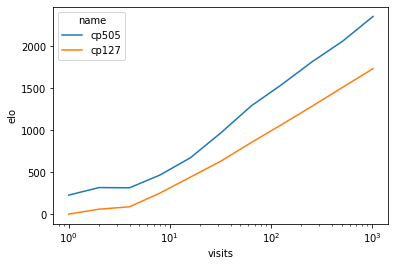

In [4]:
print(df.elo.max())
sns.lineplot(data=df, x="visits", y="elo", hue="name")
plt.xscale("log")

### Perfect victim modeling cp505

In [28]:
sgf_paths1 = game_info.find_sgf_files(pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-perfect-victim-modeling"))
sgf_paths2 = game_info.find_sgf_files(pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-ov1"))

game_infos = list(game_info.read_and_parse_all_files(
    sgf_paths1,
    fast_parse=True,
)) + list(game_info.read_and_parse_all_files(
    sgf_paths2,
    fast_parse=True,
))

df = pd.DataFrame(game_infos)
parse_for_match(df)

In [29]:
print(df.victim_name.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())

['cp505-v1' 'cp505-v16' 'cp505-v4' 'cp505-v64' 'cp505-v128' 'cp505-v32'
 'cp505-v8' 'cp505-v2' 'cp505-v256' 'cp505-v512']
[  1  16   4  64 128  32   8   2 256 512]
['adv-s34090496-v200' 'adv-s34090496-v200-ov1']


In [30]:
len(df.query("adv_name == 'adv-s34090496-v200' and victim_visits == 128"))

80

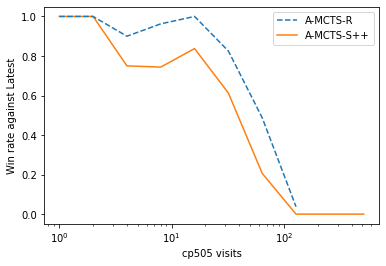

In [51]:
df.query("adv_name == 'adv-s34090496-v200' & victim_visits <= 128").groupby(
    "victim_visits"
).mean().adv_win.plot(label="A-MCTS-R", zorder=10, linestyle="--")
df.query("adv_name == 'adv-s34090496-v200-ov1'").groupby(
    "victim_visits"
).mean().adv_win.plot(label="A-MCTS-S++")
plt.xscale("log")
plt.ylabel("Win rate against Latest")
# plt.title("Adversary against cp505")
plt.xlabel("cp505 visits")
plt.legend();

### Perfect victim modeling cp127 (old adversary)

In [53]:
sgf_paths = game_info.find_sgf_files(pathlib.Path("/nas/ucb/tony/go-attack/matches/cp127-perfect-victim-modeling/sgfs"))

game_infos = list(game_info.read_and_parse_all_files(
    sgf_paths,
    fast_parse=True,
))

df = pd.DataFrame(game_infos)
parse_for_match(df)

In [54]:
print(df.victim_name.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())

['cp127-v4' 'cp127-v8' 'cp127-v16' 'cp127-v64' 'cp127-v32' 'cp127-v1'
 'cp127-v2']
[ 4  8 16 64 32  1  2]
['adv-s35783424-v200' 'adv-s35783424-v200-ov1'
 'adv-s35783424-v200-ov1-os1']


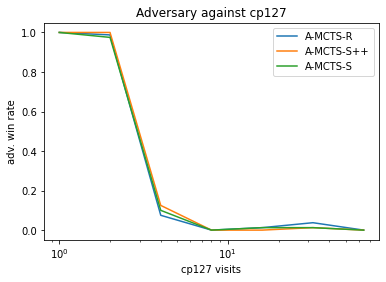

In [55]:
df.query("adv_name == 'adv-s35783424-v200'").groupby(
    "victim_visits"
).mean().adv_win.plot(label="A-MCTS-R")
df.query("adv_name == 'adv-s35783424-v200-ov1'").groupby(
    "victim_visits"
).mean().adv_win.plot(label="A-MCTS-S++")
df.query("adv_name == 'adv-s35783424-v200-ov1-os1'").groupby(
    "victim_visits"
).mean().adv_win.plot(label="A-MCTS-S")
plt.xscale("log")
plt.ylabel("adv. win rate")
plt.title("Adversary against cp127")
plt.xlabel("cp127 visits")
plt.legend()

### Strongest cp127 adversary

In [12]:
sgf_paths = game_info.find_sgf_files(pathlib.Path("/nas/ucb/tony/go-attack/matches/cp127-cp505-vs-strong-adv/sgfs/"))

game_infos = list(game_info.read_and_parse_all_files(
    sgf_paths,
    fast_parse=True,
))

df = pd.DataFrame(game_infos)
parse_for_match(df)
df["victim_net"] = df.victim_name.str.slice(stop=len("cp505"))
len(df)

8916

In [13]:
print(df.victim_name.unique())
print(df.victim_net.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())

['cp505-v32' 'cp505-v2' 'cp505-v1024' 'cp505-v16' 'cp505-v1' 'cp127-v32'
 'cp505-v8' 'cp127-v16' 'cp127-v256' 'cp505-v512' 'cp127-v2' 'cp127-v64'
 'cp127-v1' 'cp127-v8' 'cp127-v512' 'cp127-v4' 'cp505-v128' 'cp127-v128'
 'cp505-v4' 'cp505-v64' 'cp127-v1024' 'cp505-v256']
['cp505' 'cp127']
[  32    2 1024   16    1    8  256  512   64    4  128]
['adv-s178977536-os1' 'adv-s158012928' 'adv-s180832768-os1'
 'adv-s157014016-os1' 'adv-s180832768' 'adv-s179976704' 'adv-s157014016'
 'adv-s158012928-os1' 'adv-s179976704-os1' 'adv-s178977536']


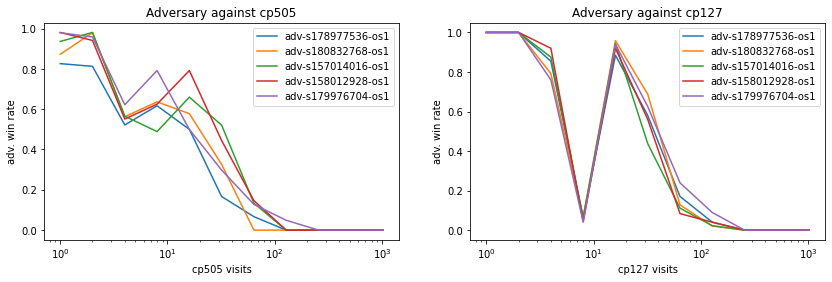

In [14]:
plt.figure(figsize=(14, 4))

victim_net: str
adv_name: str
for i, victim_net in enumerate(df.victim_net.unique()):
    plt.subplot(1, 2, i + 1)
    for adv_name in df.adv_name.unique():
        if not adv_name.endswith("-os1"):
            continue
        df.query(f"adv_name == '{adv_name}' & victim_net == '{victim_net}'").groupby("victim_visits").mean().adv_win.plot(label=adv_name)

    plt.xscale("log")
    plt.ylabel("adv. win rate")
    plt.title(f"Adversary against {victim_net}")
    plt.xlabel(f"{victim_net} visits")
    plt.legend()

### Strongest cp505 adversary

In [15]:
sgf_paths = game_info.find_sgf_files(pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-adv-emcts1.4/sgfs"))

game_infos = list(game_info.read_and_parse_all_files(
    sgf_paths,
    fast_parse=True,
))

df = pd.DataFrame(game_infos)

# Filter out games with two adversaries
adv_is_black = df.b_name.str.contains("adv")
adv_is_white = df.w_name.str.contains("adv")
df = df[~(adv_is_black & adv_is_white)].copy()
parse_for_match(df, victim_name_prefix="bot-cp127-v")
df["victim_net"] = df.victim_name.str.slice(start=len("bot-"), stop=len("bot-cp505"))
len(df)

10932

In [16]:
print(df.victim_name.unique())
print(df.victim_net.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())

['bot-cp127-v8' 'bot-cp505-v32' 'bot-cp505-v16' 'bot-cp127-v256'
 'bot-cp127-v2' 'bot-cp127-v512' 'bot-cp127-v64' 'bot-cp505-v8'
 'bot-cp127-v16' 'bot-cp127-v32' 'bot-cp127-v4' 'bot-cp127-v1'
 'bot-cp505-v1' 'bot-cp505-v128' 'bot-cp505-v64' 'bot-cp127-v128'
 'bot-cp505-v2' 'bot-cp505-v512' 'bot-cp505-v256' 'bot-cp505-v4']
['cp127' 'cp505']
[  8  32  16 256   2 512  64   4   1 128]
['adv-cp505-v1-s34090496-v600' 'adv-cp505-v1-s59042304-v600']


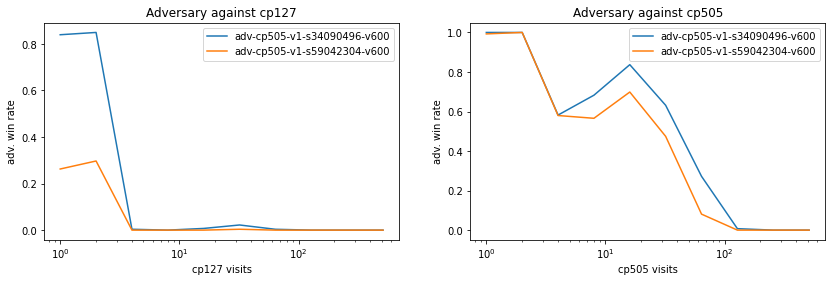

In [17]:
plt.figure(figsize=(14, 4))

victim_net: str
adv_name: str
for i, victim_net in enumerate(df.victim_net.unique()):
    plt.subplot(1, 2, i + 1)
    for adv_name in df.adv_name.unique():
        df.query(f"adv_name == '{adv_name}' & victim_net == '{victim_net}'").groupby("victim_visits").mean().adv_win.plot(label=adv_name)

    plt.xscale("log")
    plt.ylabel("adv. win rate")
    plt.title(f"Adversary against {victim_net}")
    plt.xlabel(f"{victim_net} visits")
    plt.legend()

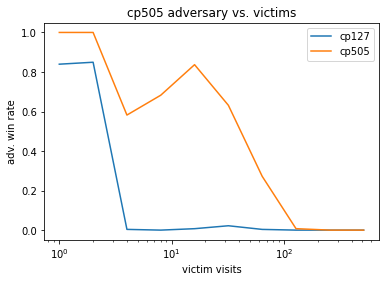

In [18]:
adv_name: str = "adv-cp505-v1-s34090496-v600"
victim_net: str
for victim_net in df.victim_net.unique():
    df.query(f"adv_name == '{adv_name}' & victim_net == '{victim_net}'").groupby(
        "victim_visits"
    ).mean().adv_win.plot(label=victim_net)

plt.xscale("log")
plt.ylabel("adv. win rate")
plt.title("cp505 adversary vs. victims")
plt.xlabel(f"victim visits")
plt.legend();

### b10 cp127 adversary

In [56]:
sgf_paths = game_info.find_sgf_files(pathlib.Path("/nas/ucb/ttseng/go_attack/match/b10-vs-v-sweep/sgfs"))

game_infos = list(game_info.read_and_parse_all_files(
    sgf_paths,
    fast_parse=True,
))

df = pd.DataFrame(game_infos)
parse_for_match(df, victim_name_prefix="bot-cp505-v")
df["victim_net"] = df.victim_name.str.slice(start=len("bot-"), stop=len("bot-cp505"))
len(df)

1100

In [57]:
print(df.victim_name.unique())
print(df.victim_net.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())

['bot-cp505-v2' 'bot-cp127-v2' 'bot-cp127-v32' 'bot-cp127-v1'
 'bot-cp127-v16' 'bot-cp505-v1' 'bot-cp505-v4' 'bot-cp505-v256'
 'bot-cp127-v512' 'bot-cp127-v64' 'bot-cp505-v512' 'bot-cp505-v8'
 'bot-cp505-v1024' 'bot-cp127-v256' 'bot-cp127-v8' 'bot-cp505-v128'
 'bot-cp505-v16' 'bot-cp127-v4' 'bot-cp505-v32' 'bot-cp127-v1024'
 'bot-cp505-v64' 'bot-cp127-v128']
['cp505' 'cp127']
[   2   32    1   16    4  256  512   64    8 1024  128]
['adv-s230746880-d58018066-v600']


In [62]:
print(len(df.query("(victim_visits == 1) & (victim_net == 'cp505')")))
df.query("(victim_visits == 1) & (victim_net == 'cp505')")

50


,b_name,w_name,victim_color,victim_name,victim_visits,adv_color,adv_name,adv_visits,adv_steps,adv_samples,...,has_button,whb,fpok,init_turn_num,used_initial_position,gtype,is_continuation,sgf_path,sgf_line,victim_net
6,bot-cp505-v1,adv-s230746880-d58018066-v600,b,bot-cp505-v1,1,w,adv-s230746880-d58018066-v600,1,0,0,...,False,0,False,0,False,normal,False,/nas/ucb/ttseng/go_attack/match/b10-vs-v-sweep...,1,cp505
12,adv-s230746880-d58018066-v600,bot-cp505-v1,w,bot-cp505-v1,1,b,adv-s230746880-d58018066-v600,600,230746880,58018066,...,False,0,False,0,False,normal,False,/nas/ucb/ttseng/go_attack/match/b10-vs-v-sweep...,1,cp505
37,bot-cp505-v1,adv-s230746880-d58018066-v600,b,bot-cp505-v1,1,w,adv-s230746880-d58018066-v600,1,0,0,...,False,0,False,0,False,normal,False,/nas/ucb/ttseng/go_attack/match/b10-vs-v-sweep...,1,cp505
52,adv-s230746880-d58018066-v600,bot-cp505-v1,w,bot-cp505-v1,1,b,adv-s230746880-d58018066-v600,600,230746880,58018066,...,False,0,False,0,False,normal,False,/nas/ucb/ttseng/go_attack/match/b10-vs-v-sweep...,1,cp505
65,bot-cp505-v1,adv-s230746880-d58018066-v600,b,bot-cp505-v1,1,w,adv-s230746880-d58018066-v600,1,0,0,...,False,0,False,0,False,normal,False,/nas/ucb/ttseng/go_attack/match/b10-vs-v-sweep...,1,cp505
72,bot-cp505-v1,adv-s230746880-d58018066-v600,b,bot-cp505-v1,1,w,adv-s230746880-d58018066-v600,1,0,0,...,False,0,False,0,False,normal,False,/nas/ucb/ttseng/go_attack/match/b10-vs-v-sweep...,1,cp505
116,adv-s230746880-d58018066-v600,bot-cp505-v1,w,bot-cp505-v1,1,b,adv-s230746880-d58018066-v600,600,230746880,58018066,...,False,0,False,0,False,normal,False,/nas/ucb/ttseng/go_attack/match/b10-vs-v-sweep...,1,cp505
126,bot-cp505-v1,adv-s230746880-d58018066-v600,b,bot-cp505-v1,1,w,adv-s230746880-d58018066-v600,1,0,0,...,False,0,False,0,False,normal,False,/nas/ucb/ttseng/go_attack/match/b10-vs-v-sweep...,1,cp505
171,adv-s230746880-d58018066-v600,bot-cp505-v1,w,bot-cp505-v1,1,b,adv-s230746880-d58018066-v600,600,230746880,58018066,...,False,0,False,0,False,normal,False,/nas/ucb/ttseng/go_attack/match/b10-vs-v-sweep...,1,cp505
210,adv-s230746880-d58018066-v600,bot-cp505-v1,w,bot-cp505-v1,1,b,adv-s230746880-d58018066-v600,600,230746880,58018066,...,False,0,False,0,False,normal,False,/nas/ucb/ttseng/go_attack/match/b10-vs-v-sweep...,1,cp505


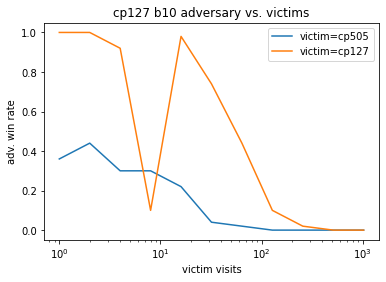

In [63]:
victim_net: str
for victim_net in df.victim_net.unique():
    df.query(f"victim_net == '{victim_net}'").groupby(
        "victim_visits"
    ).mean().adv_win.plot(label=f"victim={victim_net}")

plt.xscale("log")
plt.ylabel("adv. win rate")
plt.title("cp127 b10 adversary vs. victims")
plt.xlabel(f"victim visits")
plt.legend();

### Vary adversary visits

In [64]:
sgf_paths = game_info.find_sgf_files(pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-v64-vs-adv-1-to-8192/sgfs"))

game_infos = list(game_info.read_and_parse_all_files(
    sgf_paths,
    fast_parse=True,
))

df = pd.DataFrame(game_infos)
parse_for_match(df)
# df["victim_net"] = df.victim_name.str.slice(start=len("bot-"), stop=len("bot-cp505"))
len(df)

720

In [65]:
print(df.victim_name.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())
print(df.adv_visits.unique())

['cp505-v64']
[64]
['adv-v8192' 'adv-v2048' 'adv-v32' 'adv-v128' 'adv-v4096' 'adv-v4'
 'adv-v8' 'adv-v1' 'adv-v16' 'adv-v64' 'adv-v512' 'adv-v1024' 'adv-v256'
 'adv-v2']
[  64 2048   32 4096  128    8    1 8192    4  512   16  256    2 1024]


In [66]:
sgf_paths1 = game_info.find_sgf_files(pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-perfect-victim-modeling"))
sgf_paths2 = game_info.find_sgf_files(pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-ov1"))

game_infos = list(game_info.read_and_parse_all_files(
    sgf_paths1,
    fast_parse=True,
)) + list(game_info.read_and_parse_all_files(
    sgf_paths2,
    fast_parse=True,
))

df2 = pd.DataFrame(game_infos)
parse_for_match(df2)

In [67]:
gb = df2.query("victim_visits == 64").groupby("adv_name").mean().adv_win
gb

adv_name
adv-s34090496-v200        0.48750
adv-s34090496-v200-ov1    0.20625
Name: adv_win, dtype: float64

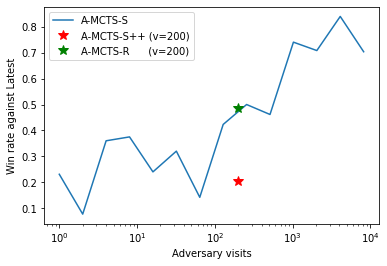

In [68]:
xs = df.groupby("adv_visits").mean().adv_win.plot(label="A-MCTS-S")

plt.plot(
    200,
    gb["adv-s34090496-v200-ov1"],
    "r*",
    label="A-MCTS-S++ (v=200)",
    markersize=10,
)

plt.plot(
    200,
    gb["adv-s34090496-v200"],
    "g*",
    label="A-MCTS-R      (v=200)",
    markersize=10,
)

# plt.title("adv. vs cp505@64")
plt.xscale("log")
plt.xlabel(f"Adversary visits")
plt.ylabel("Win rate against Latest")
plt.legend();